# Pylops - wave equation processing - frequency in first direction

### Author: M.Ravasi

Many processing step in the seismic processing chain lend naturally to the creation and solution of large scale systems of equations. 

One of the most common building blocks of wave-equation-based processing of seismic data is the so-called multi-dimensional convolution (MDC) operator. Such an operator underlies some of the most common algorithms such SRME, IME and interferometry by multi-dimensional deconvolution (MDD) and Marchenko-based redatuming. 

In this notebook I will show you how to use the **MDC** linear operator of *Pylops* and I will present two applications of such operator:

- Multi-dimensional deconvolution (MDD)
- SRME prediction

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

# just for comparison
from mdc_old import MDC as MDCold

# Application1: Multi-dimensional convolution (MDC)

The so-called multi-dimensional convolution (MDC) is a chained operator. It is composed of a forward Fourier transform a multi-dimensional integration (as shown in equation below) and an inverse Fourier transform:
    
$$ y(s,v,f) = \int_S R(s,r,f) x(v,r,f) dr$$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{D}= \mathbf{F}^H  \mathbf{R} \mathbf{F}$$

where $\mathbf{F}$ is the Fourier transform applied along the time axis  and $\mathbf{R}$ is multi-dimensional convolution kernel espressed in the equation above.

Let's start considering a single virtual source

In [2]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':60,
       'oy':0,'dy':2,    'ny':100,
       'ot':0,'dt':0.004,'nt':400,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.1]
theta_m = [0]
phi_m   = [0]
amp_m   = [1.]

t0_G    = [0.05,0.2,0.3]
theta_G = [0,0,0]
phi_G   = [0,0,0]
amp_G   = [1.,0.6,2.]


# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav =  linear2d(x,t,v,t0_m,theta_m,amp_m,wav)

# Generate operator
G,Gwav = linear3d(x,y,t,v,t0_G,theta_G,phi_G,amp_G,wav)

# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nt']-1)), m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

Let's compare with the old method

In [3]:
Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

# Old operator
MDCop=MDCold(Gwav_fft, nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], fast=False, dtype='complex64')
MDCop.matvec_count = MDCop.rmatvec_count = 0
dottest(MDCop, (2*par['nt']-1)*par['ny'], (2*par['nt']-1)*par['nx'], verb=True)

MDCopfast=MDCold(Gwav_fft, nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], fast=True, dtype='complex64')
MDCopfast.matvec_count = MDCopfast.rmatvec_count = 0
dottest(MDCop, (2*par['nt']-1)*par['ny'], (2*par['nt']-1)*par['nx'], verb=True)

# New operator
MDCop1=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], 
           twosided=True, usematmul=True)
dottest(MDCop1, MDCop1.shape[0], MDCop1.shape[1], complexflag=3, verb=True);

Dot test passed, v^H(Opu)=-976.05129066101 - u^H(Op^Hv)=-976.0512906610015
Dot test passed, v^H(Opu)=-25.10298192811797 - u^H(Op^Hv)=-25.102981928113024
Dot test passed, v^H(Opu)=-2226.7173505426035 - u^H(Op^Hv)=-2226.7173505425976


/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_32181/1910466933.py:5: DeprecationWarning: Deprecate, use new MDC...
  MDCop=MDCold(Gwav_fft, nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], fast=False, dtype='complex64')
/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_32181/1910466933.py:9: DeprecationWarning: Deprecate, use new MDC...
  MDCopfast=MDCold(Gwav_fft, nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], fast=True, dtype='complex64')


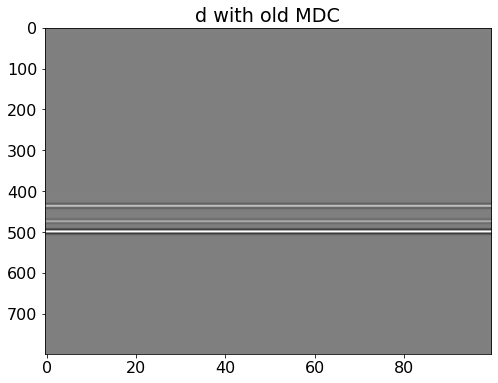

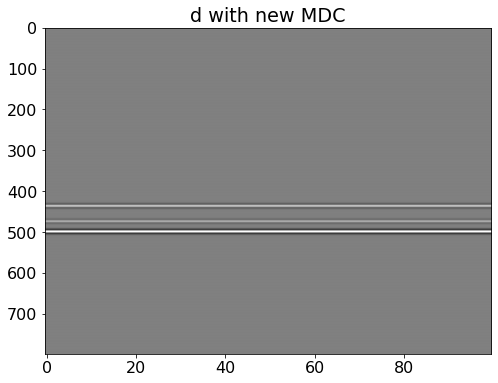

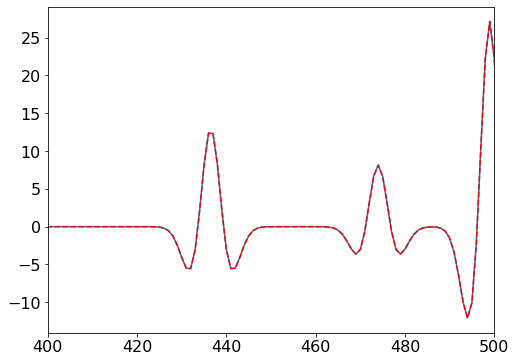

In [4]:
# Create data
d = MDCop*m.flatten()
d1 = MDCop1*m.T.flatten()

d = d.reshape(par['ny'], 2*par['nt']-1)
d1 = d1.reshape(2*par['nt']-1, par['ny'])

plt.figure()
plt.imshow(d.T, vmin=-20, vmax=20, cmap='gray')
plt.title('d with old MDC')
plt.axis('tight')

plt.figure()
plt.imshow(d1, vmin=-20, vmax=20, cmap='gray')
plt.title('d with new MDC')
plt.axis('tight')

plt.figure()
plt.plot(d[par['nx']//2])
plt.plot(d1[:, par['nx']//2], '--r')
plt.xlim(400, 500);

In [5]:
%timeit -n 50 -r 5 MDCop*m.flatten()
%timeit -n 50 -r 5 MDCopfast*m.flatten()
%timeit -n 50 -r 5 MDCop1*m.T.flatten()

9.22 ms ± 1.22 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)
5.2 ms ± 207 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
6.25 ms ± 329 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)


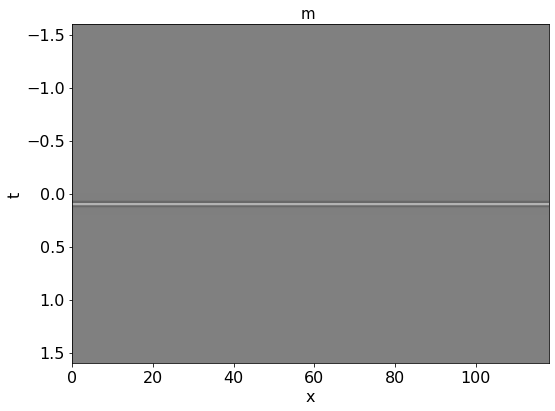

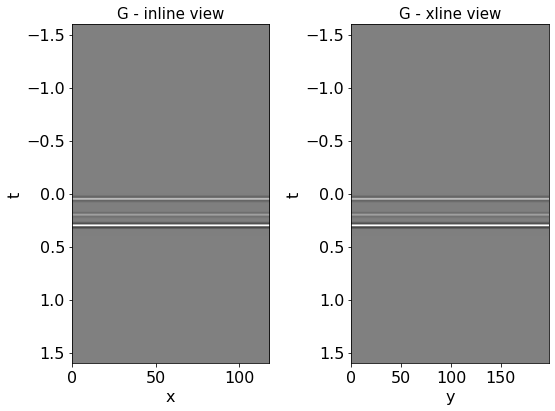

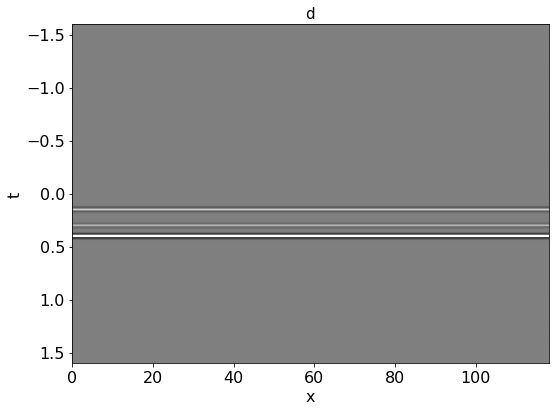

In [6]:
# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()

plt.figure()
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure()
plt.imshow(d1,aspect='auto',interpolation='nearest', vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

## Application 1: Multi-dimensional deconvolution (MDD)

MDD is an ill-solved problem, well-known in the image processing and geophysical community. It aims to remove the effect of the multidimensional convolution kernel or the so-called point-spread function (PSF). It can be written as

$$\mathbf{d}= \mathbf{D} \mathbf{m}$$

or, equivalently, by means of its normal equation

$$\mathbf{m}= (\mathbf{D}^H\mathbf{D})^{-1} \mathbf{D}^H\mathbf{d}$$

where $\mathbf{D}^H\mathbf{D}$ is generally referred to as blurring operator or PSF.

### Single virtual source

Let's take from where we left and invert our MDC operator

In [7]:
madj = MDCop1.H*d1.flatten()
minv, istop, itn, r1norm, r2norm = lsqr(MDCop1, d1.flatten(), damp=1e-10, iter_lim=10, show=1)[0:5]

madj = madj.reshape(2*par['nt']-1, par['nx'])
minv = minv.reshape(2*par['nt']-1, par['nx'])

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 79900 rows and 47940 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.032e+02  6.032e+02    1.0e+00  3.5e-01
     1  5.51900e-11   3.373e+02  3.373e+02    5.6e-01  7.0e-01   2.5e+02  1.0e+00
     2  1.45073e-10   1.969e+02  1.969e+02    3.3e-01  3.8e-01   3.6e+02  2.3e+00
     3  2.58295e-10   1.441e+02  1.441e+02    2.4e-01  3.1e-01   4.2e+02  3.6e+00
     4  4.10317e-10   1.068e+02  1.068e+02    1.8e-01  2.2e-01   4.9e+02  5.2e+00
     5 -1.95500e-09   8.800e+01  8.800e+01    1.5e-01  1.9e-01   5.3e+02  6.7e+00
     6 -2.46752e-04   7.273e+01  7.273e+01    1.2e-01  1.6e-01   5.8e+02  8.6e+00
     7  9.95927e-04   6.371e+01  6.371e+01    1.1e-01  1.4e-01   6.3e+02  1.0e+01
     8 -5.52687e-04   5.348e+01 

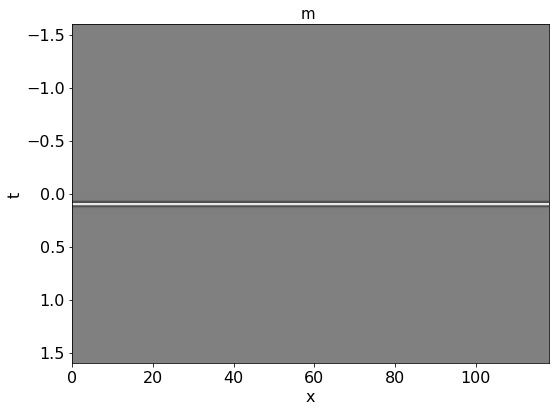

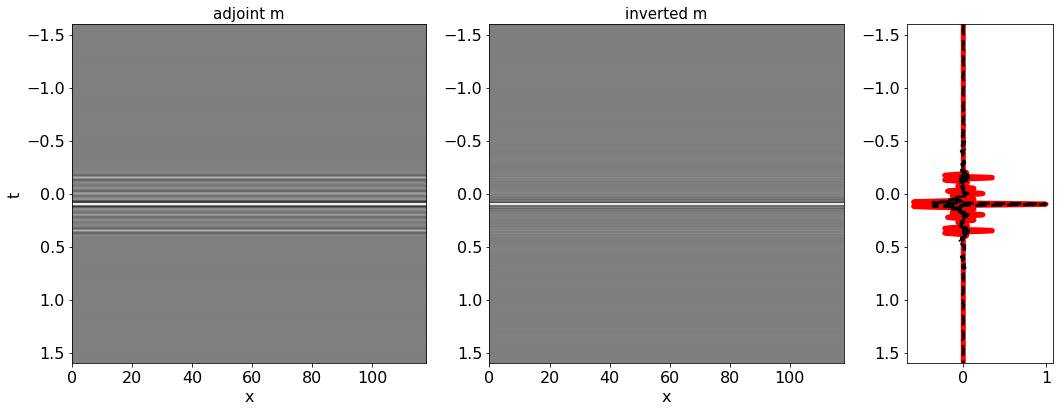

In [8]:
# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[:, int(par['nx']/2)]/np.abs(madj[:, int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[:, int(par['nx']/2)]/np.abs(minv[:, int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

We solve now the same problem with a preconditioning

$$\mathbf{d}= \mathbf{D} \mathbf{P} \mathbf{m}$$

where $\mathbf{P}$ is a masking operator that sets values in the negative part of the time axis equal to zero. This is added here as we know that our solution should be null in the negative time axis and it can be used to speed up convergence.

PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 79900 rows and 47940 cols
Prec=<47940x47940 Diagonal with dtype=float64>
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 79900 rows and 47940 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.032e+02  6.032e+02    1.0e+00  3.3e-01
     1  0.00000e+00   3.214e+02  3.214e+02    5.3e-01  7.6e-01   2.3e+02  1.0e+00
     2  0.00000e+00   1.872e+02  1.872e+02    3.1e-01  4.2e-01   3.4e+02  2.2e+00
     3  0.00000e+00   1.363e+02  1.363e+02    2.3e-01  2.9e-01   4.1e+02  3.5e+00
     4  0.00000e+00   1.057e+02  1.057e+02    1.8e-01  2.3e-01   4.7e+02  5.0e+00
     5  0.00000e+00   8.753e+

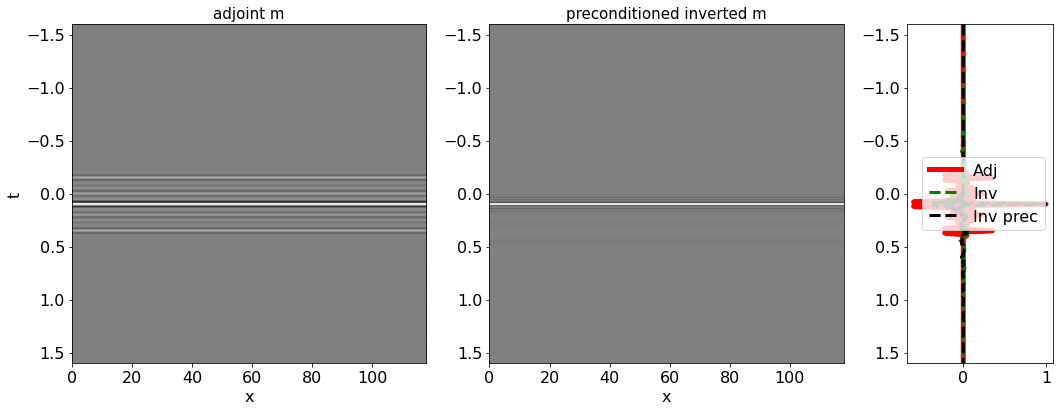

In [9]:
P = np.ones((par['nt']*2-1, par['nx']))
P[:par['nt']-1]=0
Pop = Diagonal(P)

minv_prec = preconditioned_inversion(MDCop1, d1.ravel(), Pop, **dict(damp=1e-10, iter_lim=10, show=1))[0]

minv_prec = minv_prec.reshape(2*par['nt']-1, par['nx'])

# Plotting
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv_prec,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv_prec.max(), vmax=minv_prec.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('preconditioned inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[:, int(par['nx']/2)]/np.abs(madj[:, int(par['nx']/2)]).max(), t2, 'r', lw=5, label='Adj')
ax3.plot(minv[:, int(par['nx']/2)]/np.abs(minv[:, int(par['nx']/2)]).max(), t2, '--g', lw=3, label='Inv')
ax3.plot(minv_prec[:, int(par['nx']/2)]/np.abs(minv_prec[:, int(par['nx']/2)]).max(), t2, '--k', lw=3, label='Inv prec')
ax3.set_ylim([t2[-1],t2[0]])
ax3.legend()
fig.tight_layout()

Let's now take advantage of the high level MDD routine

Dot test passed, v^H(Opu)=449.1747008321129 - u^H(Op^Hv)=449.17470083211253
Dot test passed, v^H(Opu)=-10486.86647836489 - u^H(Op^Hv)=-10486.866478364931
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 79900 rows and 47940 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.032e+02  6.032e+02    1.0e+00  3.5e-01
     1  3.40906e-18   3.373e+02  3.373e+02    5.6e-01  7.0e-01   2.5e+02  1.0e+00
     2 -3.17776e-09   1.969e+02  1.969e+02    3.3e-01  3.8e-01   3.6e+02  2.3e+00
     3 -2.57368e-09   1.441e+02  1.441e+02    2.4e-01  3.1e-01   4.2e+02  3.6e+00
     4 -4.83835e-10   1.068e+02  1.068e+02    1.8e-01  2.2e-01   4.9e+02  5.2e+00
     5 -7.98073e-10   8.800e+01  8.800e+01    1.5e-01  1.9e-01   5.3e+02  6.7e+00
     6 -2.46748e-04   7.273e+01  7.273e+01

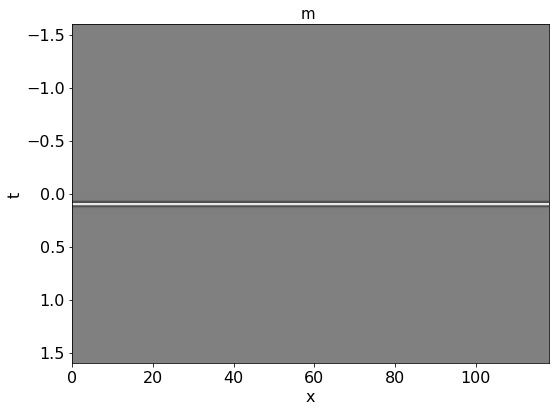

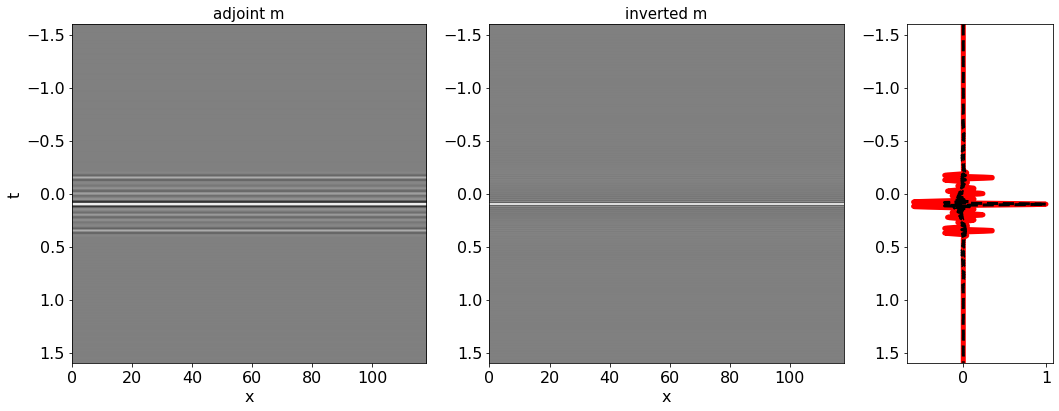

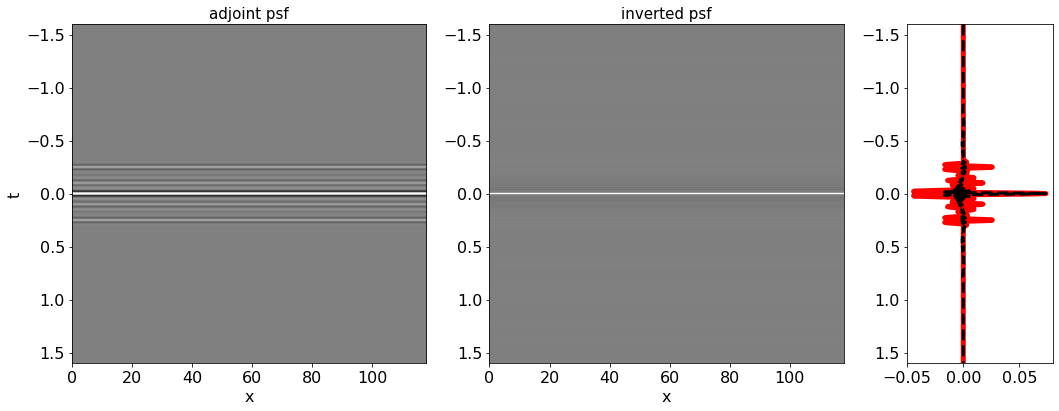

In [10]:
minv,madj,psfinv,psfadj = MDD(Gwav, d[:,par['nt']-1:], 
                              dt=par['dt'], dr=par['dx'], nfmax=799, twosided=True, 
                              adjoint=True, psf=True, dottest=True,
                              **dict(damp=1e-10, iter_lim=50, show=1))

# Plotting
plt.figure()
plt.imshow(mwav.T, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfadj.max(), vmax=psfadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfinv.max(), vmax=psfinv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(psfadj[int(par['ny']/2), int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(par['ny']/2), int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

Dot test passed, v^H(Opu)=-875.6491568308287 - u^H(Op^Hv)=-875.6491568308219
Dot test passed, v^H(Opu)=25136.95002442853 - u^H(Op^Hv)=25136.95002442845
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 79900 rows and 47940 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.032e+02  6.032e+02    1.0e+00  3.5e-01
     1  5.51900e-11   3.373e+02  3.373e+02    5.6e-01  7.0e-01   2.5e+02  1.0e+00
     2  1.45073e-10   1.969e+02  1.969e+02    3.3e-01  3.8e-01   3.6e+02  2.3e+00
     3  2.58295e-10   1.441e+02  1.441e+02    2.4e-01  3.1e-01   4.2e+02  3.6e+00
     4  4.10317e-10   1.068e+02  1.068e+02    1.8e-01  2.2e-01   4.9e+02  5.2e+00
     5 -1.95500e-09   8.800e+01  8.800e+01    1.5e-01  1.9e-01   5.3e+02  6.7e+00
     6 -2.46752e-04   7.273e+01  7.273e+01  

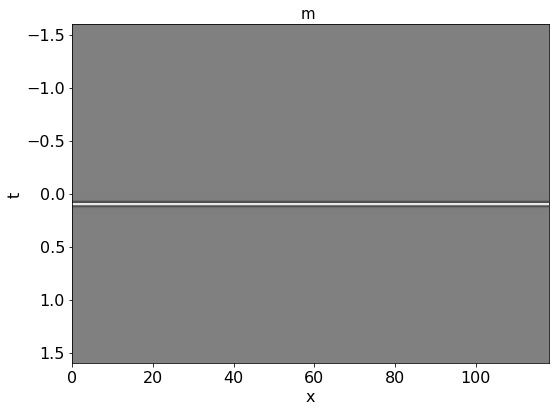

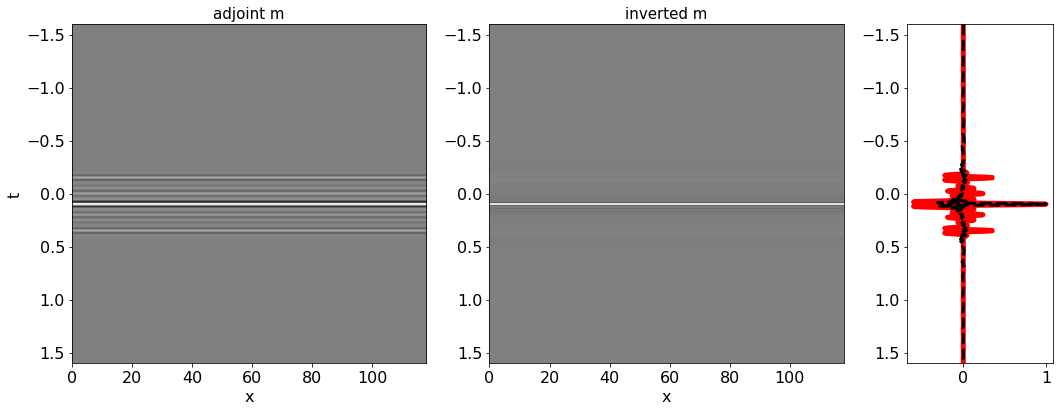

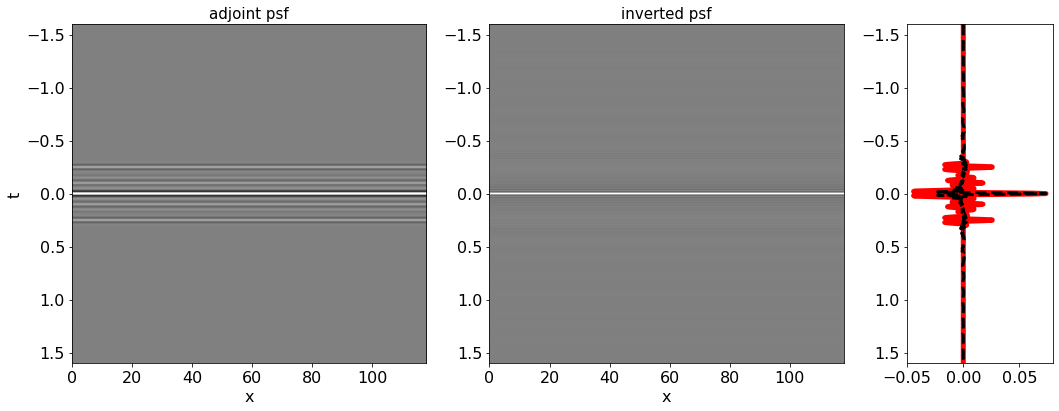

In [11]:
minv,madj,psfinv,psfadj = MDD(Gwav2, d1.T, 
                              dt=par['dt'], dr=par['dx'], nfmax=799, twosided=True, add_negative=False,
                              adjoint=True, psf=True, dottest=True, 
                              **dict(damp=1e-10, iter_lim=20, show=1))

# Plotting
plt.figure()
plt.imshow(mwav.T, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfadj.max(), vmax=psfadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfinv.max(), vmax=psfinv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(psfadj[int(par['ny']/2), int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(par['ny']/2), int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

And same with preconditioner

Dot test passed, v^H(Opu)=190.1479280622686 - u^H(Op^Hv)=190.14792806227882
PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 79900 rows and 47940 cols
Prec=<47940x47940 Diagonal with dtype=float64>
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 79900 rows and 47940 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.032e+02  6.032e+02    1.0e+00  3.3e-01
     1  0.00000e+00   3.214e+02  3.214e+02    5.3e-01  7.6e-01   2.3e+02  1.0e+00
     2  0.00000e+00   1.872e+02  1.872e+02    3.1e-01  4.2e-01   3.4e+02  2.2e+00
     3  0.00000e+00   1.363e+02  1.363e+02    2.3e-01  2.9e-01   4.1e+02  3.5e+00
     4  0.00000e+00   1.057e+02  1.

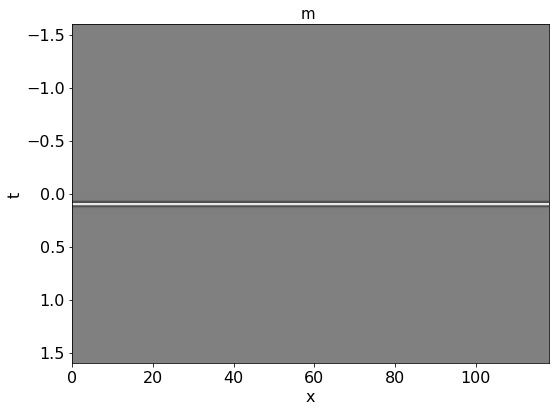

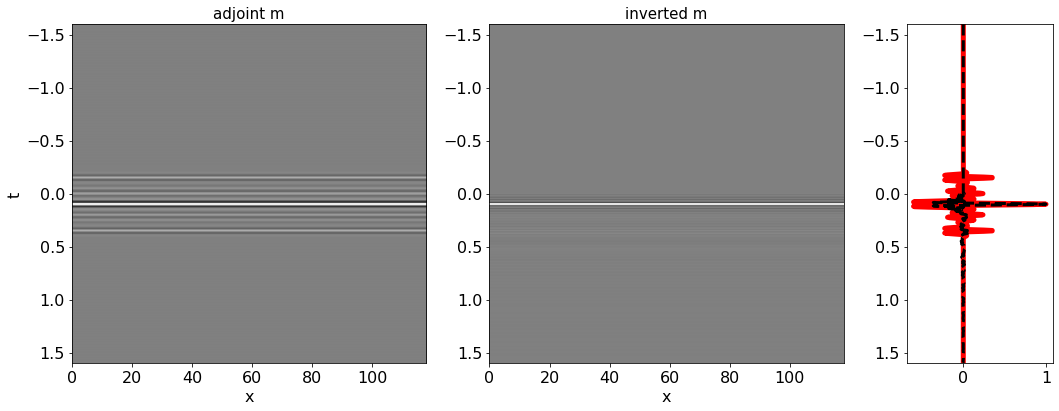

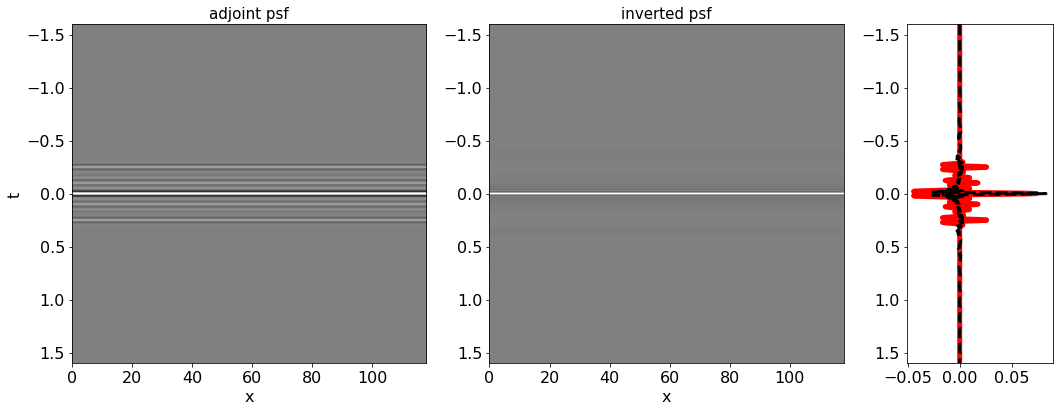

In [12]:
minv,madj = MDD(Gwav2, d1.T, 
                dt=par['dt'], dr=par['dx'], nfmax=799, twosided=True, add_negative=False,
                causality_precond=True, adjoint=True, psf=False, dottest=True, 
                **dict(damp=1e-10, iter_lim=10, show=1))

# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfadj.max(), vmax=psfadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfinv.max(), vmax=psfinv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(psfadj[int(par['ny']/2), int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(par['ny']/2), int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

Finally before moving on to the case of multiple virtual sources, let's consider a case with events in both positive and negative times for the operator

Dot test passed, v^H(Opu)=2183.325036786213 - u^H(Op^Hv)=2183.325036786212


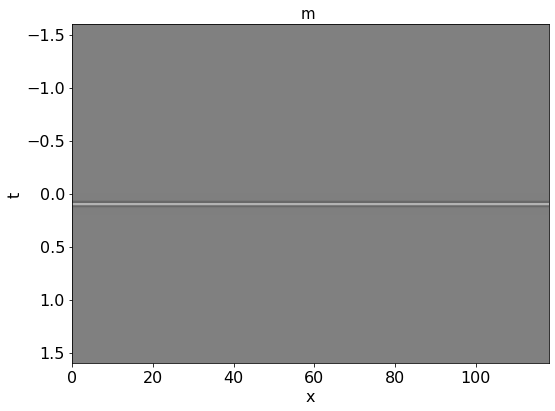

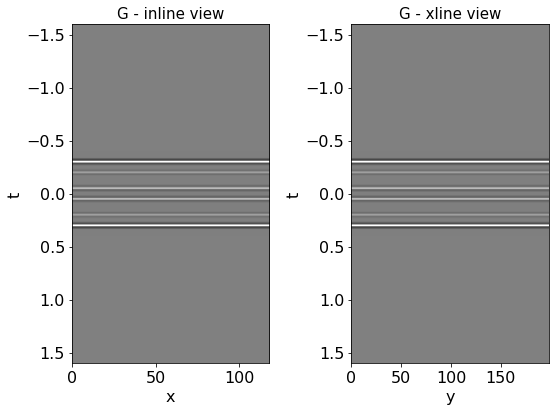

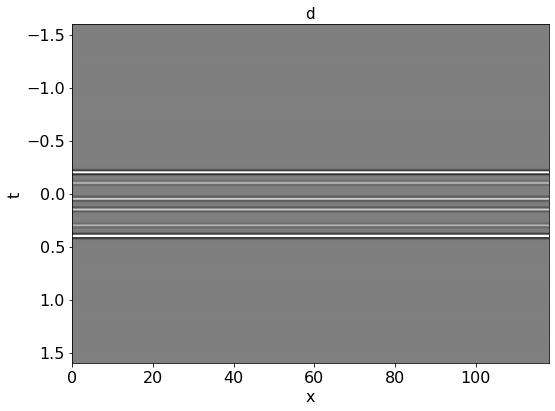

In [13]:
Gwav2 = np.concatenate((np.flip(Gwav, axis=-1), Gwav[..., 1:]), axis=-1)

Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

MDCop1=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], twosided=True)
dottest(MDCop1, MDCop1.shape[0], MDCop1.shape[1], complexflag=3, verb=True);

# Create data
d1 = MDCop1*m.T.flatten()
d1 = d1.reshape(2*par['nt']-1, par['ny'])

# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.imshow(d1,aspect='auto',interpolation='nearest', vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

Dot test passed, v^H(Opu)=-2402.02285721674 - u^H(Op^Hv)=-2402.022857216738
PreconditionedInversion
-----------------------------------------------------------------
The Operator Op has 79900 rows and 47940 cols
Prec=<47940x47940 Diagonal with dtype=float64>
-----------------------------------------------------------------
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 79900 rows and 47940 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   8.530e+02  8.530e+02    1.0e+00  3.9e-01
     1  0.00000e+00   5.510e+02  5.510e+02    6.5e-01  6.9e-01   4.4e+02  1.0e+00
     2  0.00000e+00   3.668e+02  3.668e+02    4.3e-01  4.1e-01   6.5e+02  2.4e+00
     3  0.00000e+00   2.670e+02  2.670e+02    3.1e-01  2.4e-01   7.9e+02  3.8e+00
     4  0.00000e+00   1.859e+02  1.

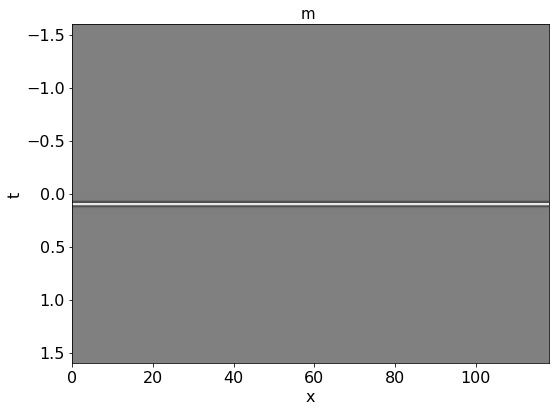

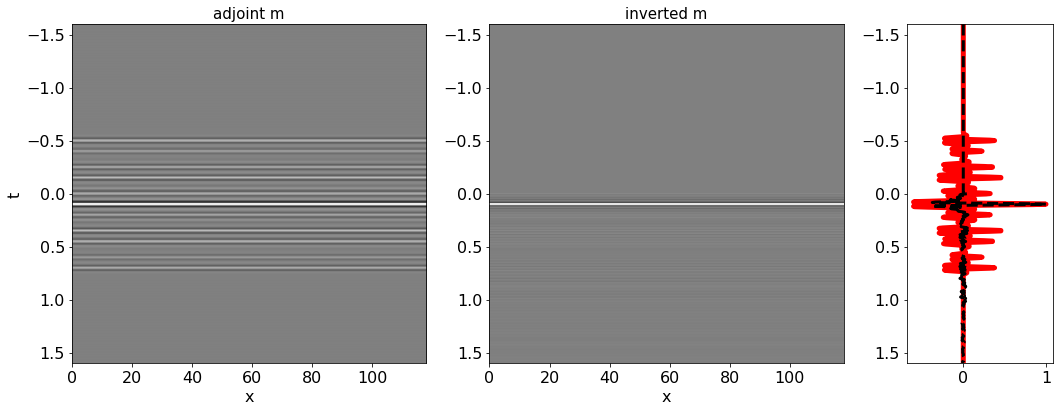

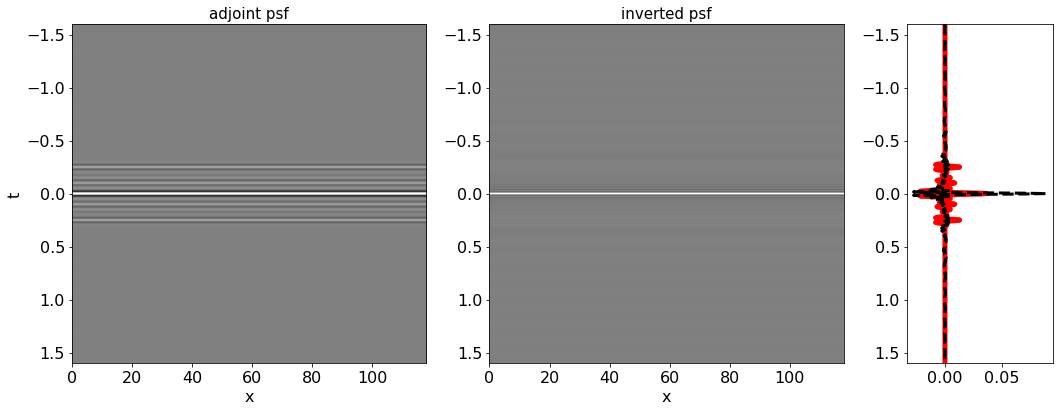

In [14]:
minv,madj = MDD(Gwav2, d1.T, 
                dt=par['dt'], dr=par['dx'], nfmax=799, twosided=True, add_negative=False,
                causality_precond=True, adjoint=True, psf=False, dottest=True, 
                **dict(damp=1e-10, iter_lim=10, show=1))

# Plotting
plt.figure()
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-mwav.max(), vmax=mwav.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfadj.max(), vmax=psfadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfinv.max(), vmax=psfinv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(psfadj[int(par['ny']/2), int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(par['ny']/2), int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

### Multiple virtual sources

We consider now a case with multiple virtual sources

In [15]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':60,
       'oy':0,'dy':2,    'ny':100,
       'ot':0,'dt':0.004,'nt':300,
       'f0': 20, 'nfmax': 201}

v       = 1500
t0_m    = [0.2]
theta_m = [0]
phi_m   = [0]
amp_m   = [1.]

t0_G    = [0.1,0.2,0.3]
theta_G = [0,0,0]
phi_G   = [0,0,0]
amp_G   = [1.,0.6,2.]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav =  linear3d(x,x,t,v,t0_m,theta_m,phi_m,amp_m,wav)

# Restrict number of virtual sources
nedge = 10
nv = par['nx'] - 2*nedge
if nedge > 0:
    m = m[:, nedge:-nedge]
    mwav = mwav[:, nedge:-nedge]

# Generate operator
G, Gwav = linear3d(x,y,t,v,t0_G,theta_G,phi_G,amp_G,wav)

# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], nv, par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], nv, par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

Let's compare with old method

In [17]:
# Create operator in frequency domain
Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

MDCop=MDCold(Gwav_fft, nt=2*par['nt']-1, nv=nv, dt=par['dt'], dr=par['dx'], twosided=True)
MDCop.matvec_count = MDCop.rmatvec_count = 0
dottest(MDCop, (2*par['nt']-1)*nv*par['ny'], (2*par['nt']-1)*nv*par['nx'], verb=True)
d = MDCop*m.flatten()
d = d.reshape(par['ny'], nv, 2*par['nt']-1)

MDCop1=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1, nv=nv, dt=par['dt'], dr=par['dx'],  twosided=True)
dottest(MDCop1, (2*par['nt']-1)*nv*par['ny'], (2*par['nt']-1)*nv*par['nx'], verb=True)
m1 = m.transpose(2,0,1)
d1 = MDCop1*m1.flatten()
d1 = d1.reshape(2*par['nt']-1, par['ny'], nv)

print(np.allclose(d,d1.transpose(1,2,0)))

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_32181/3896640535.py:5: DeprecationWarning: Deprecate, use new MDC...
  MDCop=MDCold(Gwav_fft, nt=2*par['nt']-1, nv=nv, dt=par['dt'], dr=par['dx'], twosided=True)


Dot test passed, v^H(Opu)=3269.4878194318326 - u^H(Op^Hv)=3269.4878194316916
Dot test passed, v^H(Opu)=-6583.969774877814 - u^H(Op^Hv)=-6583.969774877841
True


In [18]:
%timeit -n 50 -r 3 MDCop*m.flatten()
%timeit -n 50 -r 3 MDCop1*m1.flatten()

116 ms ± 1.3 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)
126 ms ± 2.04 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)


In [19]:
# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav2, d1.transpose(1, 2, 0), 
                              dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], twosided=True, 
                              add_negative=False, adjoint=True, psf=True, dottest=True, 
                              **dict(damp=1e-10, iter_lim=5, show=1))

Dot test passed, v^H(Opu)=-2114.943066799967 - u^H(Op^Hv)=-2114.9430667998554
Dot test passed, v^H(Opu)=-22896.45210143993 - u^H(Op^Hv)=-22896.45210143976
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2396000 rows and 1437600 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =        5
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.327e+03  3.327e+03    1.0e+00  5.7e-02
     1 -7.00009e-16   1.877e+03  1.877e+03    5.6e-01  6.6e-01   2.3e+02  1.0e+00
     2 -2.03861e-15   1.077e+03  1.077e+03    3.2e-01  3.8e-01   3.1e+02  2.3e+00
     3 -3.34507e-15   8.209e+02  8.209e+02    2.5e-01  2.7e-01   3.7e+02  3.5e+00
     4  5.31211e-08   6.243e+02  6.243e+02    1.9e-01  2.4e-01   4.2e+02  5.2e+00
     5  7.05190e-04   4.991e+02  4.991e+02    1.5e-01  2.0e-01   4.7e+02  6.9e+00
 
LSQR finished
The iteration limit h

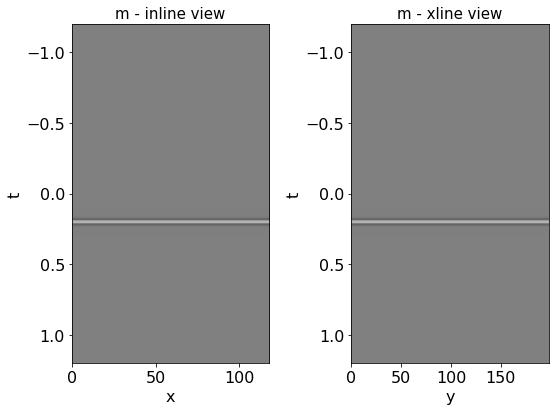

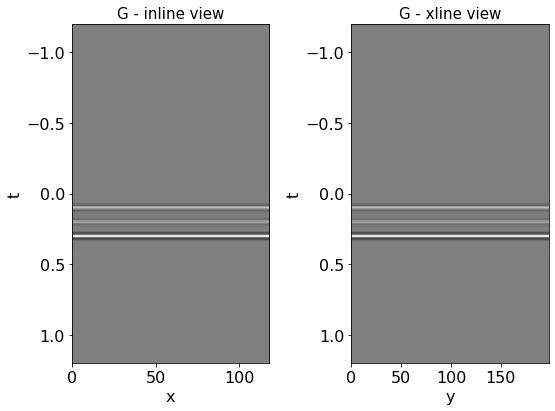

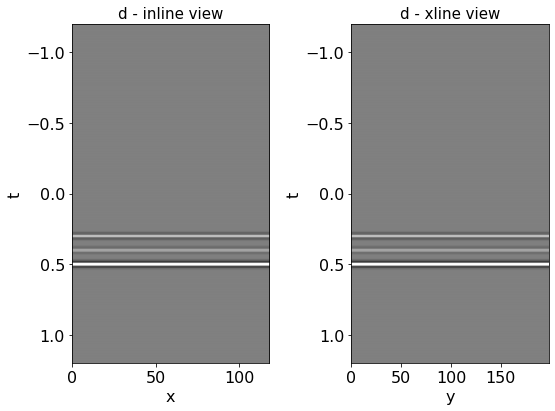

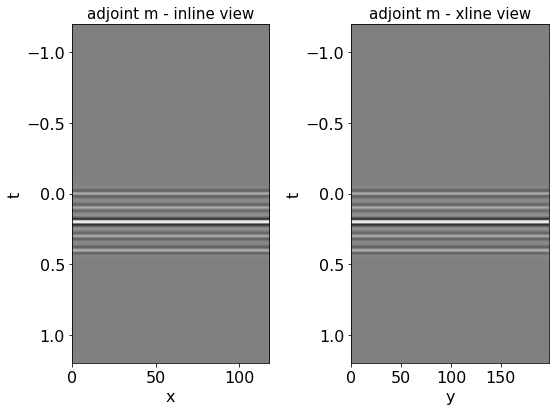

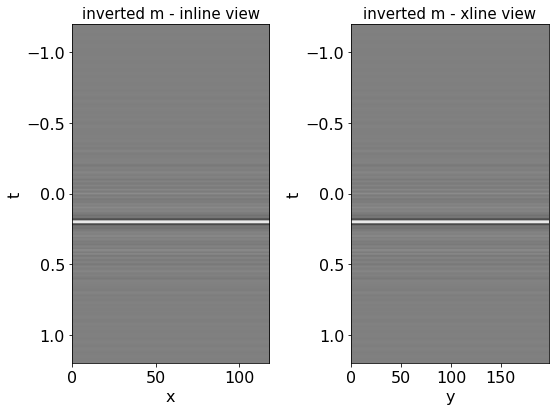

In [20]:
# Plotting
plt.figure()
plt.subplot(121)
plt.imshow(mwav[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', 
           vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(mwav[:,int(par['nx']/2),:].T,aspect='auto',interpolation='nearest', 
           vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', 
           vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', 
           vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(d1[:, int(par['ny']/2)],aspect='auto',interpolation='nearest', 
           vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(d1[:, :,int(par['nx']/2)],aspect='auto',interpolation='nearest', 
           vmin=-20, vmax=20, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('d - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(madj[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', 
           vmin=-madj.max(), vmax=madj.max(), cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('adjoint m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(madj[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', 
           vmin=-madj.max(), vmax=madj.max(), cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('adjoint m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(minv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', 
           vmin=-minv.max(), vmax=minv.max(), cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(minv[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest',            
           vmin=-minv.max(), vmax=minv.max(), cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

And finally, same as before but without padding the data and operators with zero in negative axis

In [21]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':60,
       'oy':0,'dy':2,    'ny':100,
       'ot':0,'dt':0.004,'nt':401,
       'f0': 20, 'nfmax': 200}

v       = 1500
t0_m    = [0.2]
theta_m = [0]
phi_m   = [0]
amp_m   = [1.]

t0_G    = [0.1,0.2,0.5]
theta_G = [0,0,0]
phi_G   = [0,0,0]
amp_G   = [1.,0.6,2.]


# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav =  linear3d(x,x,t,v,t0_m,theta_m,phi_m,amp_m,wav)

# Restrict number of virtual sources
nedge = 20
nv = par['nx'] - 2*nedge
if nedge > 0:
    m = m[:, nedge:-nedge]
    mwav = mwav[:, nedge:-nedge]

# Generate operator
G,Gwav = linear3d(x,y,t,v,t0_G,theta_G,phi_G,amp_G,wav)

Gwav_fft = np.fft.rfft(Gwav, par['nt'], axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

In [22]:
MDCop=MDCold(Gwav_fft, nt=par['nt'], 
             nv=nv, dt=par['dt'], dr=par['dx'], 
             twosided=False)
MDCop.matvec_count = MDCop.rmatvec_count = 0
dottest(MDCop, par['nt']*nv*par['ny'], par['nt']*nv*par['nx'], verb=True)
d = MDCop*m.flatten()
d = d.reshape(par['ny'], nv, par['nt'])

MDCop1=MDC(Gwav_fft.transpose(2,0,1), nt=par['nt'], 
           nv=nv, dt=par['dt'], dr=par['dx'], 
           twosided=False)
dottest(MDCop1, par['nt']*nv*par['ny'], par['nt']*nv*par['nx'], verb=True)
m1 = m.transpose(2,0,1)
d1 = MDCop1*m1.flatten()
d1 = d1.reshape(par['nt'], par['ny'], nv)

print(np.allclose(d,d1.transpose(1,2,0)))

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_32181/1586750240.py:1: DeprecationWarning: Deprecate, use new MDC...
  MDCop=MDCold(Gwav_fft, nt=par['nt'],


Dot test passed, v^H(Opu)=2296.3215555707793 - u^H(Op^Hv)=2296.321555570743
Dot test passed, v^H(Opu)=-7044.309003789742 - u^H(Op^Hv)=-7044.309003789791
True


In [23]:
%timeit -n 50 -r 3 MDCop*m.flatten()
%timeit -n 50 -r 3 MDCop1*m1.flatten()

56.6 ms ± 5.63 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)
58.7 ms ± 3.47 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)


In [24]:
%timeit -n 50 -r 3 MDCop.H*d.flatten()
%timeit -n 50 -r 3 MDCop1.H*d.flatten()

73.6 ms ± 4.69 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)
59.2 ms ± 3.27 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)


In [25]:
cProfile.run('MDCop*m.flatten()', sort=0)
cProfile.run('MDCop1*m.flatten()', sort=0)

         674 function calls in 0.067 seconds

   Ordered by: call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      206    0.025    0.000    0.060    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      200    0.000    0.000    0.000    0.000 multiarray.py:736(dot)
      200    0.000    0.000    0.025    0.000 <__array_function__ internals>:2(dot)
        6    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
        4    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        3    0.000    0.000    0.000    0.000 {method 'reshape' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        2    0.030    0.015    0.030    0.015 {built-in method numpy.fft._pocketfft_internal.execute}
        2    0.000    0.000    0.000    0.000 {method 'flatten' of 'numpy.ndarray' objects}
        2    0.000    0.000    0.000    0.000 {method 's

(-0.5, 19.5, 400.5, -0.5)

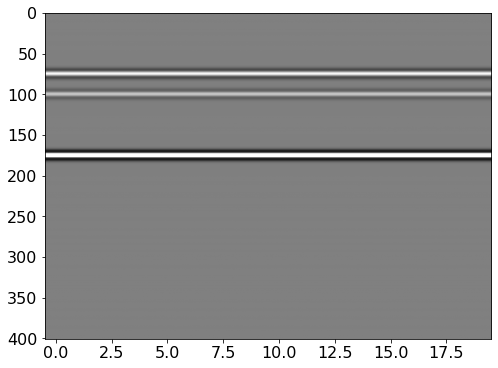

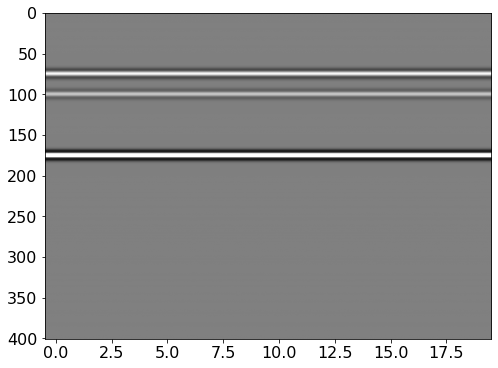

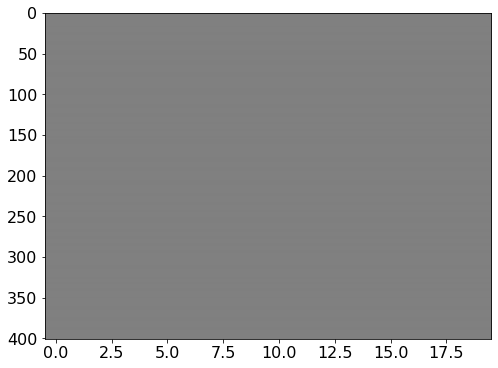

In [26]:
plt.figure()
plt.imshow(d[par['ny']//2].T, vmin=-10, vmax=10, cmap='gray')
plt.axis('tight')

plt.figure()
plt.imshow(d1[:, par['ny']//2], vmin=-10, vmax=10, cmap='gray')
plt.axis('tight')

plt.figure()
plt.imshow(d[par['ny']//2].T-d1[:, par['ny']//2], vmin=-10, vmax=10, cmap='gray')
plt.axis('tight')

In [27]:
MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=par['nt'], 
          nv=nv, dt=par['dt'], dr=par['dx'], 
          twosided=False)
dottest(MDCop, par['nt']*(par['nx']-2*nedge)*par['ny'], par['nt']*par['nx']*(par['nx']-2*nedge), verb=True)

# Create data
d = MDCop*m.transpose(2,0,1).flatten()
d = d.reshape(par['nt'], par['ny'], nv)

# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav, d.transpose(1, 2, 0), dt=par['dt'], dr=par['dx'], 
                              nfmax=par['nfmax'], twosided=False, 
                              adjoint=True, psf=True, dottest=True, 
                              **dict(damp=1e-10, iter_lim=10, show=1))

Dot test passed, v^H(Opu)=8949.452350856645 - u^H(Op^Hv)=8949.452350856645
Dot test passed, v^H(Opu)=-2809.616198021008 - u^H(Op^Hv)=-2809.616198021017
Dot test passed, v^H(Opu)=-2342.05640234212 - u^H(Op^Hv)=-2342.0564023421484
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 802000 rows and 481200 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.925e+03  1.925e+03    1.0e+00  7.8e-02
     1  3.94816e-08   1.018e+03  1.018e+03    5.3e-01  7.4e-01   1.8e+02  1.0e+00
     2 -3.75097e-03   6.502e+02  6.502e+02    3.4e-01  4.0e-01   2.6e+02  2.2e+00
     3  2.38545e-03   4.508e+02  4.508e+02    2.3e-01  2.6e-01   3.1e+02  3.6e+00
     4  3.15546e-04   3.432e+02  3.432e+02    1.8e-01  2.0e-01   3.4e+02  5.1e+00
     5 -1.42451e-03   2.705e+02  2.705e+02    1

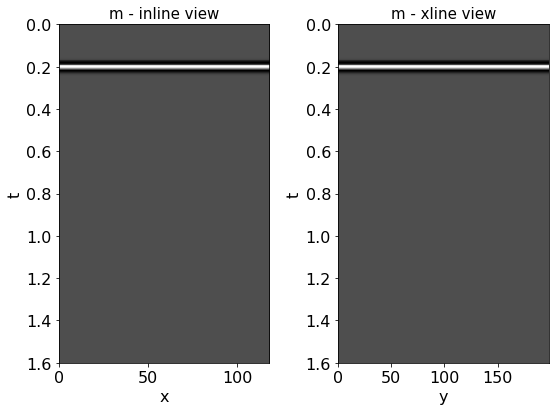

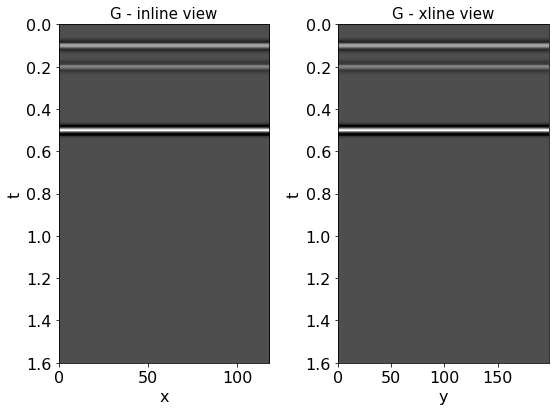

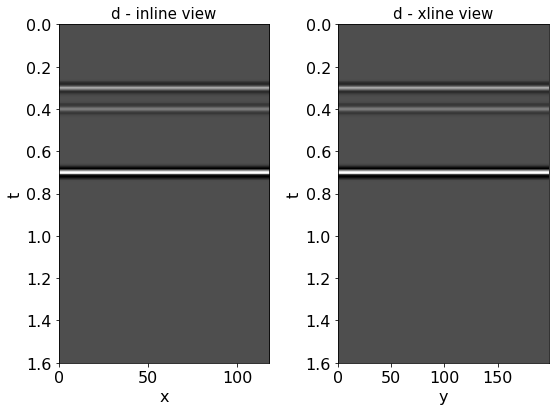

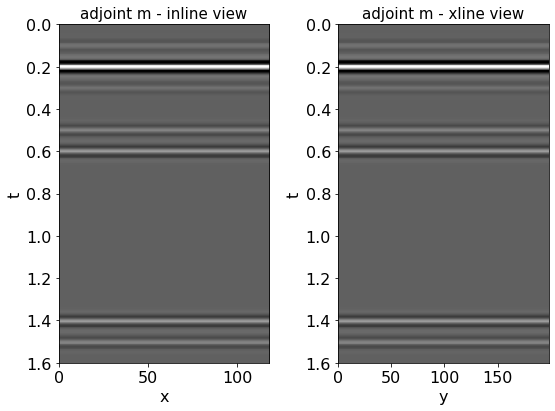

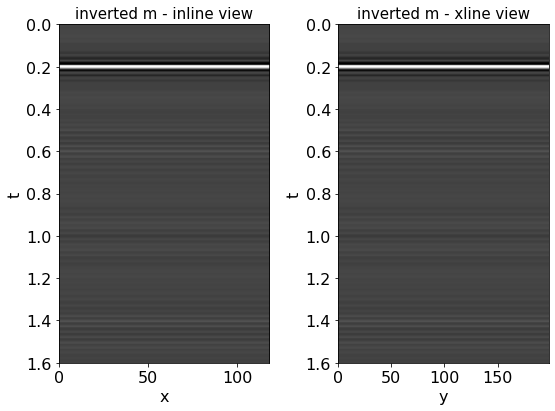

In [28]:
# Plotting
plt.figure()
plt.subplot(121)
plt.imshow(mwav[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(mwav[:, nv//2].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(Gwav[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav[:, int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(d[:, int(par['ny']/2)],aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('d - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(d[:, :, nv//2],aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('d - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(madj[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('adjoint m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(madj[:, nv//2].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('adjoint m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure()
plt.subplot(121)
plt.imshow(minv[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()))
plt.title('inverted m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(minv[:, nv//2].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t.max(),t.min()))
plt.title('inverted m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

Let's now repeat the same exercise with hyperbolic events

In [29]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]


# Create taper for operator
tap = taper3d(par['nt'], [par['ny'], par['nx']], [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
#G,Gwav = hyperbolic3d(x,y,t,t0_G,vrms_G,vrms_G,amp_G,wav)
G,Gwav = np.zeros((par['ny'],par['nx'],par['nt'])), np.zeros((par['ny'],par['nx'],par['nt']))
for iy,y0 in enumerate(y):
    G[iy],Gwav[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)

G,Gwav = G*tap,Gwav*tap

In [30]:
# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], twosided=True)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True);

# Create data
d = MDCop * m.T.flatten()
d = d.reshape(2*par['nt']-1, par['ny'])

Dot test passed, v^H(Opu)=-4606.252900942747 - u^H(Op^Hv)=-4606.252900942748


In [31]:
# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav2, d.T, 
                              dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav=wav,
                              twosided=True, add_negative=False, 
                              adjoint=True, psf=True, dottest=True, 
                              **dict(damp=1e-4, iter_lim=30, show=1))

Dot test passed, v^H(Opu)=1339.7623416493507 - u^H(Op^Hv)=1339.7623416493457
Dot test passed, v^H(Opu)=-78166.05899642411 - u^H(Op^Hv)=-78166.05899642369
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 80699 rows and 48739 columns
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.836e+02  2.836e+02    1.0e+00  4.6e-01
     1  0.00000e+00   1.840e+02  1.840e+02    6.5e-01  6.8e-01   1.7e+02  1.0e+00
     2  0.00000e+00   1.267e+02  1.267e+02    4.5e-01  4.2e-01   2.5e+02  2.4e+00
     3  0.00000e+00   9.672e+01  9.672e+01    3.4e-01  2.9e-01   3.2e+02  3.8e+00
     4  0.00000e+00   7.788e+01  7.788e+01    2.7e-01  2.2e-01   3.7e+02  5.4e+00
     5  0.00000e+00   6.362e+01  6.362e+01    2.2e-01  1.9e-01   4.1e+02  7.2e+00
     6  0.00000e+00   5.448e+01  5.448e+01

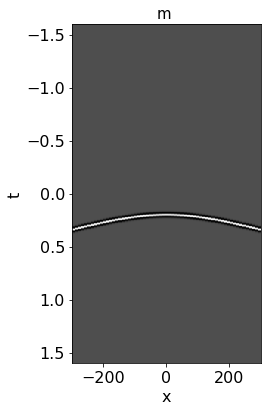

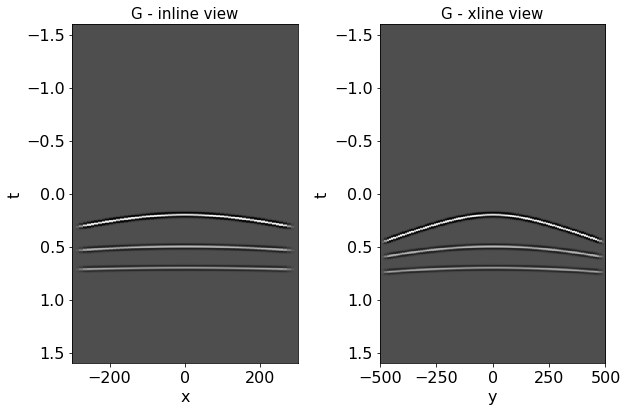

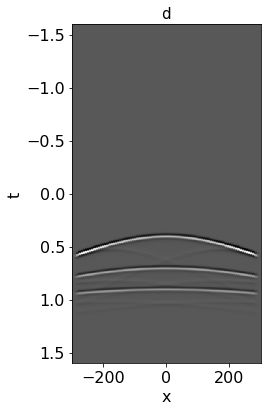

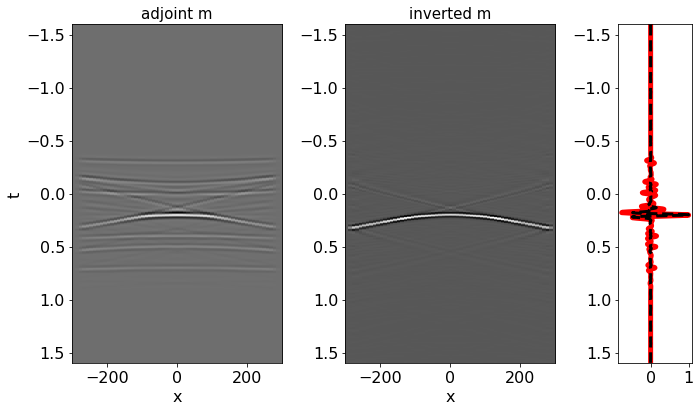

In [32]:
# Plotting
plt.figure(figsize=(4,6))
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(4,6))
plt.imshow(d, aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()


fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')
ax2.imshow(minv.T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')
ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r',   lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

And multiple virtual sources to finish

In [33]:
# Generate model
m, mwav =  hyperbolic3d(x,x,t,t0_m,vrms_m,vrms_m,amp_m,wav)
m, mwav = np.zeros((par['nx'],par['nx'],par['nt'])), np.zeros((par['nx'],par['nx'],par['nt']))
for ix,x0 in enumerate(x):
    m[ix],mwav[ix] = hyperbolic2d(x-x0,t,t0_m,vrms_m,amp_m,wav)

# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nx'], par['nt']-1)), mwav), axis=-1)

MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1,
          nv=par['nx'], dt=par['dt'], dr=par['dx'], 
          twosided=True)
dottest(MDCop, (2*par['nt']-1)*par['nx']*par['ny'],(2*par['nt']-1)*par['nx']*par['nx'], verb=True)

# Create data
d = MDCop*m.transpose(2,0,1).flatten()
d = d.reshape(2*par['nt']-1, par['ny'], par['nx'])

# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav2, d.transpose(1, 2, 0), dt=par['dt'], dr=par['dx'], 
                              nfmax=par['nfmax'], twosided=True, wav=wav,
                              adjoint=True, add_negative=False, psf=True, dottest=True, 
                              **dict(damp=1e-10, iter_lim=30, show=1))

Dot test passed, v^H(Opu)=-79215.9304820671 - u^H(Op^Hv)=-79215.93048206643
Dot test passed, v^H(Opu)=-31112.975747956596 - u^H(Op^Hv)=-31112.97574795812
Dot test passed, v^H(Opu)=-14631.250621339183 - u^H(Op^Hv)=-14631.250621339348
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 4922639 rows and 2973079 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.251e+03  2.251e+03    1.0e+00  5.9e-02
     1  0.00000e+00   1.326e+03  1.326e+03    5.9e-01  7.4e-01   1.6e+02  1.0e+00
     2  0.00000e+00   9.145e+02  9.145e+02    4.1e-01  4.1e-01   2.5e+02  2.3e+00
     3  0.00000e+00   6.872e+02  6.872e+02    3.1e-01  3.0e-01   3.1e+02  3.7e+00
     4  0.00000e+00   5.600e+02  5.600e+02    2.5e-01  2.2e-01   3.6e+02  5.3e+00
     5  0.00000e+00   4.629e+02  4.629e+0

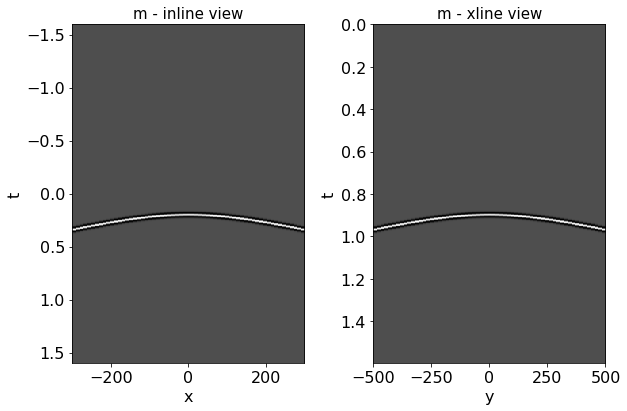

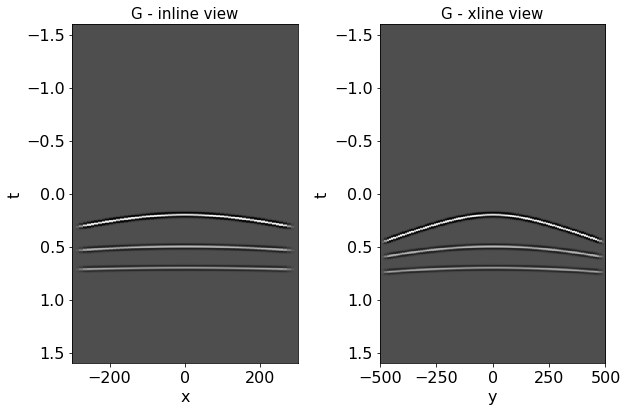

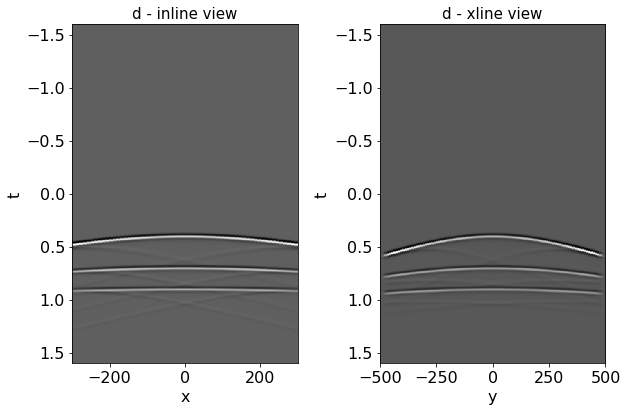

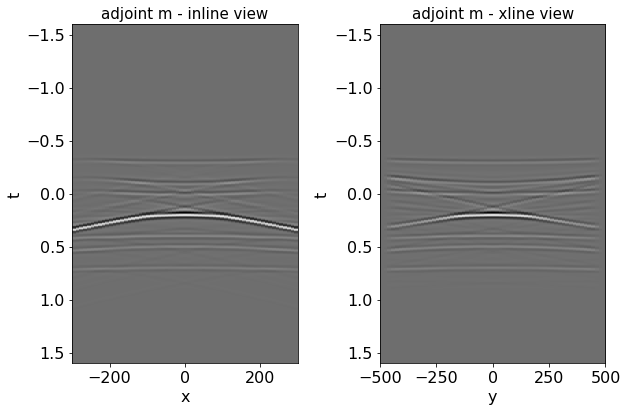

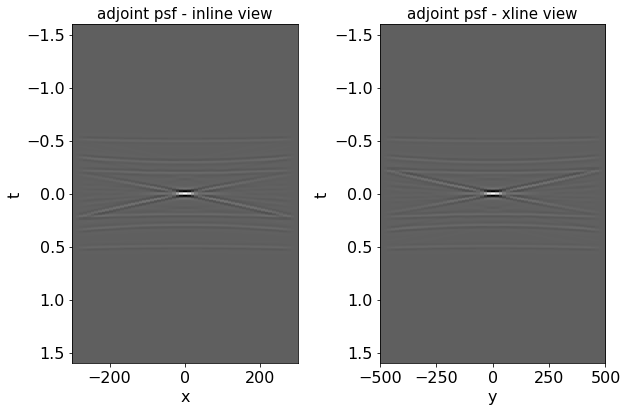

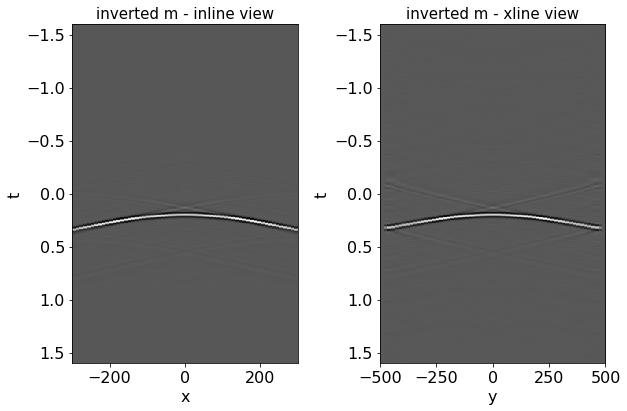

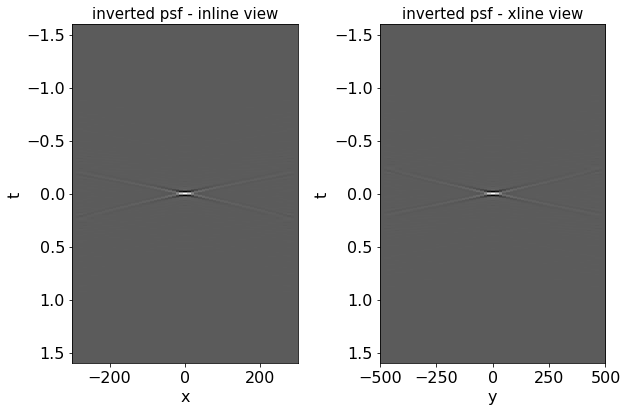

In [34]:
# Plotting
plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(mwav[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(mwav[:,int(par['nx']/2),:].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t.min()))
plt.title('m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(d[:, int(par['ny']/2)],aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(d[:, :,int(par['nx']/2)],aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('d - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(madj[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('adjoint m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(madj[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('adjoint m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(psfadj[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('adjoint psf - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(psfadj[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('adjoint psf - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()


plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(minv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted m - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(minv[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted m - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(psfinv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('inverted psf - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(psfinv[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('inverted psf - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

# Application2: SRME prediction

The same operator can be used to perform the prediction step of SRME algorithm. 

We first create a primary only data called $P_0 = R*W$ where $R$ is the medium reflectivity and $W$ the source wavelet. 

We then create the full data by evaluating the following series

$$\mathbf{p} = \sum_{i=1}^{n_{iter}} (r\mathbf{R})^i \mathbf{p_0}$$

where $r$ is the free-surface reflectivity.

Finally we make an approximate (kinematically correct but dynamically incorrect) estimate of the free-surface multiples by simple cross-correlation of the data

$$\mathbf{M} =  \mathbf{P} \mathbf{p}$$

where $\mathbf{P}$ is a MDC linear operator that convolves the input with the full data.

In [35]:
###### Input parameters
par = {'ox':-500,  'dx':5,     'nx':201,
       'ot':0,     'dt':0.004, 'nt':301,
       'f0':40,    'nfmax':151}

t0_P    = [0.2]
vrms_P  = [1400.]
amp_P   = [1.]
r       = -.9

niters  = 6

# Create axis
t,t2,x,_ = makeaxis(par)

# Create wavelets
wav      = ricker(t[:41], f0=par['f0'])[0] # sampled to 0.5ms

# Create taper for operator
tap = taper3d(par['nt'], [par['nx'], par['nx']], [15,15], tapertype='hanning')

# Generate primary data
R, P0 = np.zeros((par['nx'],par['nx'],par['nt'])), np.zeros((par['nx'],par['nx'],par['nt']))
for ix,x0 in enumerate(x):
    R[ix],P0[ix] = hyperbolic2d(x-x0,t,t0_P,vrms_P,amp_P,wav)
R, P0 = R*tap,P0*tap

# Create operator
R_fft = np.fft.rfft(R, par['nt'], axis=-1) / np.sqrt(par['nt'])
R_fft = R_fft[...,:par['nfmax']].transpose(2, 0, 1)
Rop=MDC(R_fft, nt=par['nt'], nv=par['nx'], dt=par['dt'], dr=par['dx'], twosided=False)
dottest(Rop, par['nt']*par['nx']*par['nx'], par['nt']*par['nx']*par['nx'], verb=True)

# Create full data
P  = P0.copy().transpose(2, 0, 1)
dP = P0.copy().T
for i in range(niters):
    print('Construct contribution %d/%d' %(i,niters))
    dP = (r*Rop*dP.flatten()).reshape(par['nt'], par['nx'], par['nx'])
    P += dP
    
# Estimate multiples
P_fft = np.fft.rfft(P, par['nt'], axis=0)
P_fft = P_fft[:par['nfmax']]
Pop=MDC(P_fft, nt=par['nt'], nv=par['nx'], dt=par['dt'], dr=par['dx'], twosided=False)
dottest(Pop, par['nt']*par['nx']*par['nx'], par['nt']*par['nx']*par['nx'], verb=True)

Mest = -Pop*P.flatten()
Mest = Mest.reshape(par['nt'], par['nx'], par['nx'])

Dot test passed, v^H(Opu)=-1356.9092358160606 - u^H(Op^Hv)=-1356.909235816073
Construct contribution 0/6
Construct contribution 1/6
Construct contribution 2/6
Construct contribution 3/6
Construct contribution 4/6
Construct contribution 5/6
Dot test passed, v^H(Opu)=21861.56592233691 - u^H(Op^Hv)=21861.56592233728


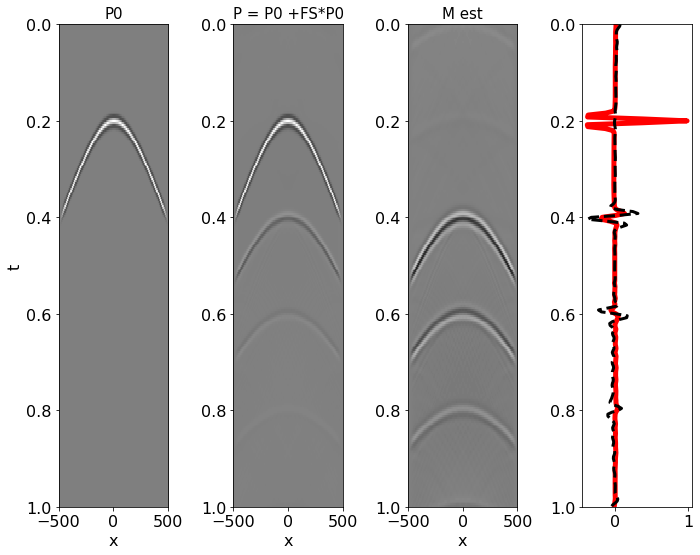

In [36]:
# Plotting
tmax=1.

fig, axs = plt.subplots(1,4,figsize=(10,8))
axs[0].imshow(P0[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
axs[0].set_title('P0', fontsize=15)
axs[0].set_xlabel('x'),axs[0].set_ylabel('t')
axs[0].set_ylim([tmax,t[0]])

axs[1].imshow(P[:, int(par['nx']/2)],aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
axs[1].set_title('P = P0 +FS*P0', fontsize=15)
axs[1].set_xlabel('x'),axs[0].set_ylabel('t')
axs[1].set_ylim([tmax,t[0]])

axs[2].imshow(Mest[:, int(par['nx']/2)]/Mest.max(),aspect='auto',interpolation='nearest', cmap='gray',
           extent=(x.min(),x.max(),t.max(),t.min()), vmin=-1, vmax=1)
axs[2].set_title('M est', fontsize=15)
axs[2].set_xlabel('x'),axs[0].set_ylabel('t')
axs[2].set_ylim([tmax,t[0]])

axs[3].plot(P[:, int(par['nx']/2),int(par['nx']/2)].T/np.abs(P).max(),       t, 'r',   lw=5)
axs[3].plot(Mest[:, int(par['nx']/2),int(par['nx']/2)].T/np.abs(Mest).max(), t, '--k', lw=3)
axs[3].set_ylim([tmax,t[0]])
plt.tight_layout()